<a href="https://colab.research.google.com/github/Hendmohamed24/EAST/blob/master/Alibaba_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://huggingface.co/docs/transformers/en/model_doc/mgp-str

In [ ]:
! pip install transformers torch

In [ ]:
from transformers import MgpstrProcessor, MgpstrForSceneTextRecognition
import requests
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
processor = MgpstrProcessor.from_pretrained('alibaba-damo/mgp-str-base')
model = MgpstrForSceneTextRecognition.from_pretrained('alibaba-damo/mgp-str-base')

In [ ]:
# load image from the IIIT-5k dataset
url = "/content/img_109.jpg"
#image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = Image.open(url).convert("RGB")
pixel_values = processor(images=image, return_tensors="pt").pixel_values
outputs = model(pixel_values)

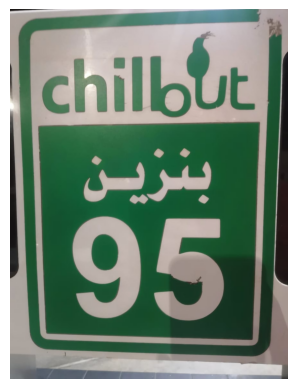

In [ ]:
# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
generated_text = processor.batch_decode(outputs.logits)

In [ ]:
generated_text

{'generated_text': ['a'],
 'scores': [tensor(0.0889, grad_fn=<SelectBackward0>)],
 'char_preds': ['ta'],
 'bpe_preds': ['a'],
 'wp_preds': ['be']}

In [ ]:
#1. Prepare the Environment,You will also need CUDA (if you have an NVIDIA GPU) to accelerate training.

pip install torch torchvision torchaudio
pip install transformers datasets


In [ ]:
# a simplified code outline for fine-tuning a model in PyTorch:

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from model import MGP_STR  # Adjust with the correct import based on the repository

# Load pretrained MGP-STR model
model = MGP_STR.from_pretrained("path_to_pretrained_model")

# Modify the final layer if necessary for Arabic text (e.g., number of output classes)
model.fc_out = torch.nn.Linear(in_features, num_arabic_classes)  # Update accordingly

# Prepare dataset and DataLoader
train_dataset = ArabicTextDataset('path_to_train_data', transform=transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to your input size
    transforms.ToTensor(),
]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CTCLoss()  # CTC loss is commonly used for text recognition tasks

# Training loop
model.train()
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_model.pth')


In [ ]:
#anew one
pip install torch torchvision torchaudio
pip install transformers datasets opencv-python
pip install albumentations  # For augmentation (optional)


In [ ]:
#2. Download the Pretrained MGP-STR Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection import faster_rcnn
from torch.optim import Adam
import os
import cv2
import numpy as np
from pathlib import Path

# Load the Pretrained MGP-STR model (adjust path to your actual model)
class MGPSTRModel(nn.Module):
    def __init__(self):
        super(MGPSTRModel, self).__init__()
        # Define the layers and structure of the MGP-STR model here
        # If you have the MGP-STR architecture, load it from a pretrained source
        # Example, load a pretrained backbone like a Vision Transformer
        # and adapt it for scene text recognition
        self.backbone = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.fc_out = nn.Linear(256, 85)  # Adjust based on Arabic character set size

    def forward(self, x):
        # Implement forward pass based on the actual model architecture
        features = self.backbone(x)
        output = self.fc_out(features)
        return output


# Custom Dataset class for Arabic Text Recognition
class ArabicTextDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.labels = self.load_labels(label_file)

    def load_labels(self, label_file):
        # Assuming labels are in a text file, adjust according to your dataset format
        with open(label_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        labels = [line.strip() for line in lines]
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load the image
        img_path = os.path.join(self.image_dir, f"{idx}.jpg")  # Adjust extension if necessary
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        label = self.labels[idx]

        # Apply transformation (resize, normalize, etc.)
        if self.transform:
            image = self.transform(image)

        return image, label


# Data Preprocessing (Resize, Normalization, etc.)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Change to required size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Adjust normalization
])

# Create Dataset and DataLoader
train_dataset = ArabicTextDataset(image_dir='path_to_images', label_file='path_to_labels.txt', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = MGPSTRModel().cuda()  # Move model to GPU if available

# Loss function (CTC Loss is commonly used for OCR)
criterion = nn.CTCLoss(blank=0).cuda()

# Optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Fine-Tuning Loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()  # Ensure labels are also on the correct device

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss (CTC Loss)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_mgp_str.pth')

